In [70]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

import jaxley as jx
from jaxley.channels import Leak

from jaxley_mech.channels import aoyama00 as ao
from jaxley_mech.channels.chen24 import Phototransduction
from jaxley_mech.synapses.feedback_ribbon import FeedbackRibbon

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:

prefix = 'Phototransduction'
params = {
    f"{prefix}_sigma": 10.45696787, # /s, opsin decay rate constant
    f"{prefix}_phi": 9.89562738, # /s, PDE decay rate constant
    f"{prefix}_eta": 763.29787849, # /s, PDE dark activate rate
    f"{prefix}_gamma": 19.36875132, # unitless, Opsin gain
    f"{prefix}_beta": 2.65338436, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01037261, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4.08266326, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3.00251023, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.34845409, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 20.70855004, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1.03434373, # μM, Ca2+ concentration in dark  
    "length": 16, # um
    "radius": 1, # um
    "Leak_gLeak": 3e-3
}

cone = jx.Cell(jx.Branch(ncomp=3), [-1])
cone.branch(0).comp(0).insert(Phototransduction(solver='newton'))
cone.branch(0).comp(0).insert(Leak())
cone.set('axial_resistivity', 5e8)

for name, param in params.items():
    cone.set(name, param)

length = 5 #um 
radius = 1 #um

hor = jx.Cell(jx.Branch(ncomp=3), parents=[-1])
hor.insert(ao.Leak())
hor.insert(ao.Kar())
hor.insert(ao.Kto())
hor.insert(ao.Kdr())
hor.insert(ao.Na())

hor.set('length', length)
hor.set('radius', radius)

net = jx.Network([hor, cone])

In [72]:
def create_stim_plot(ts, stim_start, stim_stop, test_conditions, ax_pparms=None):

    stimulus = np.zeros_like(ts) + 100
    stimulus[(ts > stim_start) & (ts < stim_stop)] = 50_000
    stimulus = jnp.array(stimulus)
    tskip=0.8e3
    plot_start = int(np.where(ts > tskip)[0][0])
    plot_ts = (ts[plot_start:] - stim_start)
        
    to_record = ['v cone', 'FeedbackSynapse_VGCC_i', 'FeedbackSynapse_Ca', 'FeedbackSynapse_exo', 'FeedbackSynapse_iGlu', 'v hor']

    results = {}
    for condition, params in test_conditions.items():
        
        synapse = FeedbackRibbon(name='FeedbackSynapse',solver='newton')
        synapse.reset_all_feedbacks()
        
        net = jx.Network([hor, cone])
        jx.connect(net.cell(1).branch(0).comp(0), net.cell(0).branch(0).comp(0), synapse)

        for param, value in params:
            net.set(param, value)
            
        net.clamp("Phototransduction_Stim", stimulus, verbose=False)

        for rec in to_record:
            if rec == 'v cone':
                net.cell([1]).branch(0).comp(0).record('v', verbose=False)
            elif rec == 'v hor':
                net.cell([0]).branch(0).comp(0).record('v', verbose=False)
            else:
                net.record(rec, verbose=False)
            
        s = jx.integrate(net, delta_t=0.05)
        results[condition] = s
        
    fig, axs = plt.subplots(2, 3, figsize=(7.5, 5.5), sharex=False)
    axs = axs.flatten()
    
    titles = ['$V_{C}$', '$I_{Ca}$', '$[Ca]$', '$Glu$', '$I_{Glu}$', '$V_{H}$']
    ylabels = ['V (mV)', 'I (pA)', '(a.u.)', "(a.u.)", 'I (p.A.)', 'V (mV)']

    for i, (ax, title, ylabel) in enumerate(zip(axs, titles, ylabels)):
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        if i == 0:
            ax.axvspan(0, stim_stop-stim_start, color='yellow', alpha=0.3)
        else:
            ax.axvspan(0, stim_stop-stim_start, color='black', alpha=0.1)
        if ax_pparms:
            ax.set(**ax_pparms)
        
        
    for  condition, result in results.items():
        if condition == 'no fb':
            alpha = 0.4
        else:
            alpha = 1.0
        
        axs[0].plot(plot_ts, result[0][plot_start+1:], color='#800080', linewidth=1, alpha=alpha)
        axs[1].plot(plot_ts, result[1][plot_start+1:], color='#6495ED', linewidth=1, alpha=alpha)
        axs[2].plot(plot_ts, result[2][plot_start+1:] / result[2][plot_start+1], color='#6495ED', linewidth=1, alpha=alpha)
        axs[3].plot(plot_ts, result[3][plot_start+1:] / result[3][plot_start+1], color='#800000', linewidth=1, alpha=alpha)
        axs[4].plot(plot_ts, result[4][plot_start+1:], color='#800000', linewidth=1, alpha=alpha)
        axs[5].plot(plot_ts, result[5][plot_start+1:], color='#FA8072', linewidth=1, alpha=alpha)

    for ax in axs[:3]:
        ax.set_xticklabels([])
    fig.supxlabel("Time (ms)")
        
    fig.tight_layout(pad=0.5)
    plt.show()

### Synapse state plots

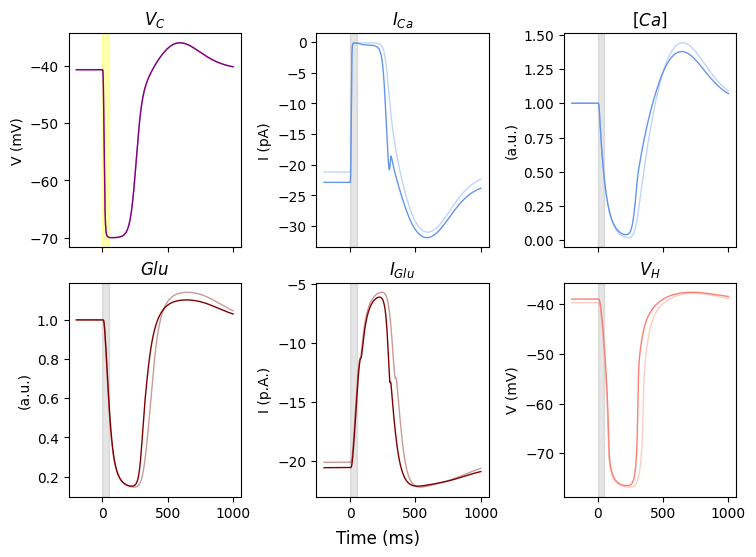

In [73]:
# use only ephaptic feedback

dt = 0.05
ts = np.arange(0, 2e3, dt)
stim_start = 1.0e3
stim_stop = 1.05e3

ax_pparms = dict(xticks=[0,500,1000])


test_conditions = {
    'no fb':[
        ('FeedbackSynapse_feedback', 0.0)
    ],
    'ephaptic fb':[
        ('FeedbackSynapse_Ephaptic_active', 1.0)
    ]
}


create_stim_plot(ts, stim_start, stim_stop, test_conditions, ax_pparms=ax_pparms)

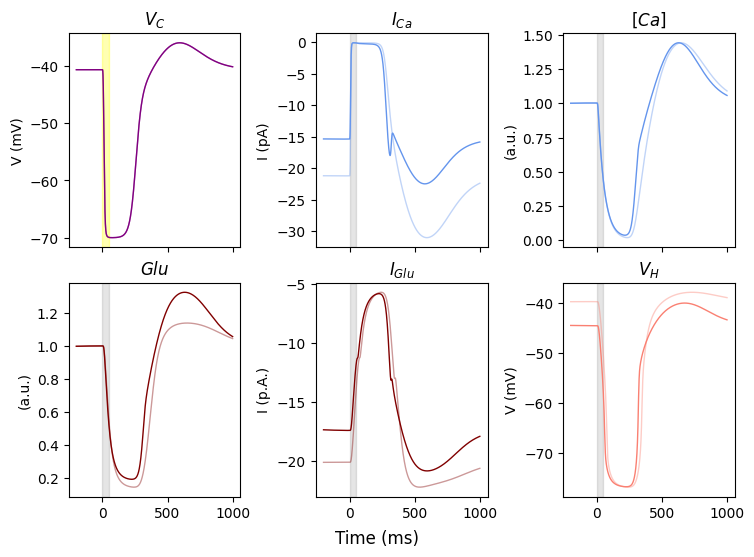

In [74]:
# use multiple feedback mechanisms (ephaptic, Panx1, and NHE)

dt = 0.05
ts = np.arange(0, 2e3, dt)
stim_start = 1.0e3
stim_stop = 1.05e3

ax_pparms = dict(xticks=[0,500,1000])


test_conditions = {
    'no fb':[
        ('FeedbackSynapse_feedback', 0.0)
    ],
    'ephaptic fb':[
        ('FeedbackSynapse_Ephaptic_active', 1.0),
        ('FeedbackSynapse_Panx1_active', 1.0),
        ('FeedbackSynapse_NHE_active', 1.0)
    ]
}


create_stim_plot(ts, stim_start, stim_stop, test_conditions, ax_pparms=ax_pparms)

### Ica shift plot

In [75]:
def run_cone_voltage_clamp(stim_voltages, ts, dt, parms):
    is_ca = []
    glus = []
    
    synapse = FeedbackRibbon(name='FeedbackSynapse', solver='newton')
    synapse.reset_all_feedbacks()
    
    net = jx.Network([hor, cone])
    jx.connect(net.cell(1).branch(0).comp(0), net.cell(0).branch(0).comp(0), synapse)
    
    for param, value in parms:
        net.set(param, value)
    
    for stim_voltage in stim_voltages:
        net.delete_recordings()
        net.delete_clamps()
        net.cell(1).branch(0).comp(0).clamp("v", stim_voltage.repeat(ts.shape[0]), verbose=False)
        net.record("FeedbackSynapse_VGCC_i", verbose=False)
        net.record("FeedbackSynapse_exo", verbose=False)
        
        s = jx.integrate(net, delta_t=dt)
        is_ca.append(s[0][-1])
        glus.append(s[1][-1])
    
    return is_ca, glus


def plot_voltage_clamp_results(stim_voltages, results, colors):
    fig, axs = plt.subplots(1, 2 ,figsize=(7.5, 4.4))
    
    # Plot simulation results
    for i, condition in enumerate(results.keys()):
        (is_ca, glus) = results[condition]
        color = colors[i]
        # normalize glu release
        glus /= np.max(glus)
        axs[0].plot(stim_voltages, is_ca, '-o', label=condition, color=color, linewidth=1, markersize=4)
        axs[1].plot(stim_voltages, np.gradient(glus, stim_voltages), '-o', label=condition, color=color, linewidth=1, markersize=4)
    
    # Set titles and labels
    axs[0].set_ylabel('I (pA)')
    axs[0].set_xlabel('V (mV)')
    axs[0].set_title('Ca current')
    axs[0].legend()
    
    axs[1].set_ylabel('(a.u./mV)')
    axs[1].set_xlabel('V (mV)') 
    axs[1].set_title('Glu sensitivity')
    
    plt.tight_layout()
    plt.show()
    

In [76]:
# Define simulation parameters
stim_voltages = np.arange(-85,-19, 10)
dt = 0.05
tmax = 1.5e3  # ms
ts = np.arange(0, tmax, dt)

# Run simulations and collect results
test_conditions = {
    'no fb':[
        ('FeedbackSynapse_feedback', 0.0)
    ],
    'ephaptic fb':[
        ('FeedbackSynapse_Ephaptic_active', 1.0),
        ('FeedbackSynapse_Panx1_active', 1.0),
        ('FeedbackSynapse_NHE_active', 1.0)
    ]
}

results_voltage_clamp = {}
for condition, params in test_conditions.items():
    is_ca, glus = run_cone_voltage_clamp(stim_voltages,ts, dt, params)
    results_voltage_clamp[condition] = (is_ca, glus)

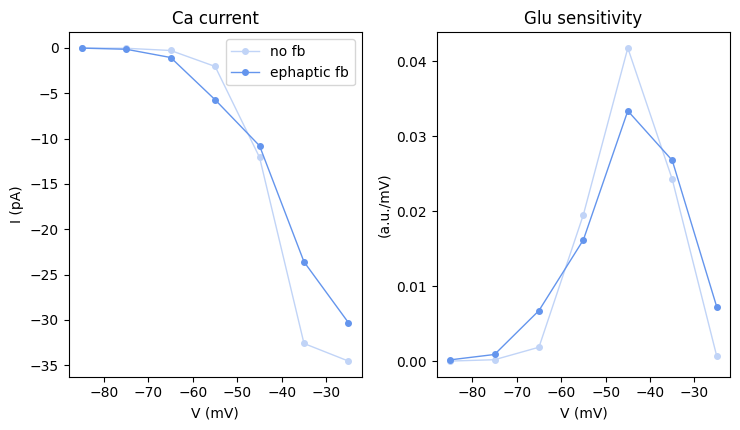

In [77]:
conditions = ['no feedback', 'feedback']
colors = ['#c1d4f7', '#6495ED']
plot_voltage_clamp_results(stim_voltages, results_voltage_clamp, colors)

In [78]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-04-09 15:56:59CEST

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 9.1.0

jaxley_mech: 0.3.0
jax        : 0.5.3
numpy      : 2.2.4
ipykernel  : 6.29.5
jaxley     : 0.5.0
debugpy    : 1.8.13
matplotlib : 3.10.1

Watermark: 2.5.0

